#### Open AI Gym Example


In [23]:
import gym
from IPython.display import Image
import numpy as np

In [28]:
env = gym.make('NChain-v0')
env.reset()

0

### Open AI Gym's NChain Enviornment

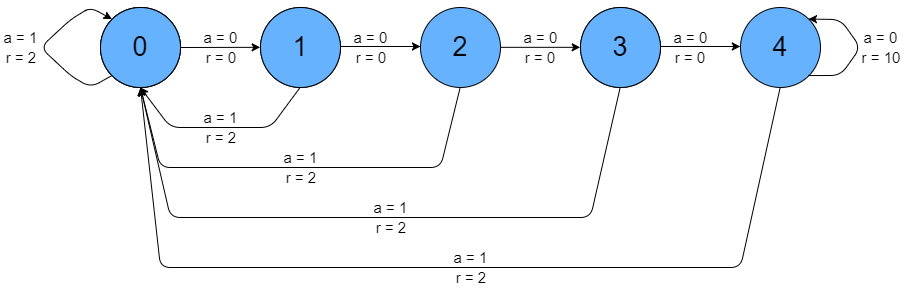

In [20]:
Image(filename='NChain-illustration.png')

Above is the state of the current enviornment. Our goal is to recieve as much reward possible from the 4th state.

In [8]:
env.step(1)

(0, 2, False, {})

In [9]:
env.step(0)

(1, 0, False, {})

In [10]:
env.step(0)

(2, 0, False, {})

In [11]:
env.step(0)

(3, 0, False, {})

In [12]:
env.step(0)

(0, 2, False, {})

In [13]:
env.step(0)

(1, 0, False, {})

In [14]:
env.step(0)

(2, 0, False, {})

In [15]:
env.step(0)

(3, 0, False, {})

In [16]:
env.step(0)

(4, 0, False, {})

In [17]:
env.step(0)

(4, 10, False, {})

Above is the state, reward and completed variable 

### A first naive heursitic for reinforcement learning

In order to find good policy pi which maps states to actions in optimal ways to maximize rewards. 
Let's conceptualized a table and call it reward.

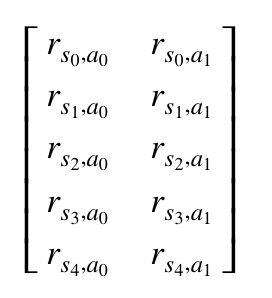

In [22]:
Image(filename="reward.png")

In [30]:
def naive_sum_reward_agent(env, num_episodes=500):
    # this is the table that will hold our summated rewards for
    # each action in each state
    r_table = np.zeros((5, 2))
    for g in range(num_episodes):
        s = env.reset()
        done = False
        while not done:
            if np.sum(r_table[s, :]) == 0:
                # make a random selection of actions
                a = np.random.randint(0, 2)
            else:
                # select the action with highest cummulative reward
                a = np.argmax(r_table[s, :])
            new_s, r, done, _ = env.step(a)
            r_table[s, a] += r
            s = new_s
    return r_table

In [31]:
print(naive_sum_reward_agent(env))

[[     0. 640030.]
 [     0. 128300.]
 [     0.  25488.]
 [     0.   4980.]
 [     0.   2926.]]


Above is a reward table where each index is consider to be the state and the value is the award.
Reason for weird results is because once actions have reward, the agent will always chose that current action, kinda "locked in"

### Delayed reward reinforcement learning

Idea of propagating possible reward from the best possible actions in the future states is a core component for Q Learning.

In Q Learning, the Q Value of each state is updated when the relevant information is made avaliable.

QLearning formula is : 

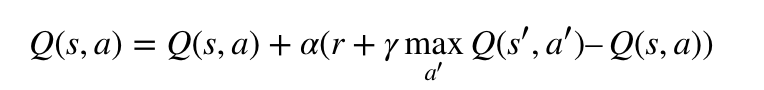

In [32]:
Image(filename='QLearning.png')

In [33]:
# Q Learning in pratice.

def q_learning_with_table(env, num_episodes=500):
    q_table = np.zeros((5, 2))
    y = 0.95
    lr = 0.8
    for i in range(num_episodes):
        s = env.reset()
        done = False
        while not done:
            if np.sum(q_table[s,:]) == 0:
                # make a random selection of actions
                a = np.random.randint(0, 2)
            else:
                # select the action with largest q value in state s
                a = np.argmax(q_table[s, :])
            new_s, r, done, _ = env.step(a)
            q_table[s, a] += r + lr*(y*np.max(q_table[new_s, :]) - q_table[s, a])
            s = new_s
    return q_table

Function is almost the same as before, only difference is that the variabes y specifies the discounting factor for gamma and lr is the Q Table updating learning rate. 

In addition, the - q_table is an easy way to get max value from q_table

In [34]:
print(q_learning_with_table(env))

[[ 0.         30.01336973]
 [ 0.         30.26275027]
 [28.75322405  0.        ]
 [ 0.         27.03016098]
 [ 0.         29.44907105]]


Values of table still does not make much sense, we ar not giving enough exploration.

### Q Learning with ϵ - greedy action selection

Here we are looking the best set of actions for the enviornment and avoiding the agent from locking and giving space for exploration alternatives.


ϵ - greedy policy in reinforcement learning basically is the same as greedy policy, except there is a value ϵ which sets the decay over time. 
#### The kicker.
If a number is selected which is less than this value, an action is chosen completely at random. This allows use to do some explorations. This value can be scaled back over time to allow algorithm to concenrare more on exploting best trateges that it has found. 


In [35]:
def eps_greedy_q_learning_with_table(env, num_episodes=500):
    q_table = np.zeros((5, 2))
    y = 0.95
    eps = 0.5
    lr = 0.8
    decay_factor = 0.999
    for i in range(num_episodes):
        s = env.reset()
        eps *= decay_factor
        done = False
        while not done:
            # select the action with highest cummulative reward
            if np.random.random() < eps or np.sum(q_table[s, :]) == 0:
                a = np.random.randint(0, 2)
            else:
                a = np.argmax(q_table[s, :])
            # pdb.set_trace()
            new_s, r, done, _ = env.step(a)
            q_table[s, a] += r + lr * (y * np.max(q_table[new_s, :]) - q_table[s, a])
            s = new_s
    return q_table

In [36]:
print(eps_greedy_q_learning_with_table(env))

[[66.93483226 73.29868578]
 [71.12290145 69.28900962]
 [76.07851189 51.83573935]
 [74.61467048 51.04574889]
 [82.76413446 52.26926601]]


### Difference between Delayed Reward Reinforcement Learning.

if np.random.random() < eps or np.sum(q_table[s, :]) == 0:
    a = np.random.randint(0, 2)
else:
    a = np.argmax(q_table[s, :])

where the first componenet being selected, between 0 and 1, and determining if this is below eps. If so, action will be selected randomly. Second part of the if is to check if there are no values stored in the q_table so far. 

If neither of both, we simply use the highest q value.

### Comparing the methods.
We are going to use the three models trained and test over 100 iterations to see which agent perfroms the best over a test game.


In [37]:
def run_game(table, env):
    s = env.reset()
    tot_reward = 0
    done = False
    while not done:
        a = np.argmax(table[s, :])
        s, r, done, _ = env.step(a)
        tot_reward += r
    return tot_reward

In [38]:
def test_methods(env, num_iterations=100):
    winner = np.zeros((3,))
    for g in range(num_iterations):
        m0_table = naive_sum_reward_agent(env, 500)
        m1_table = q_learning_with_table(env, 500)
        m2_table = eps_greedy_q_learning_with_table(env, 500)
        m0 = run_game(m0_table, env)
        m1 = run_game(m1_table, env)
        m2 = run_game(m2_table, env)
        w = np.argmax(np.array([m0, m1, m2]))
        winner[w] += 1
        print("Game {} of {}".format(g + 1, num_iterations))
    return winner

In [39]:
print(test_methods(env))

Game 1 of 100
Game 2 of 100
Game 3 of 100
Game 4 of 100
Game 5 of 100
Game 6 of 100
Game 7 of 100
Game 8 of 100
Game 9 of 100
Game 10 of 100
Game 11 of 100
Game 12 of 100
Game 13 of 100
Game 14 of 100
Game 15 of 100
Game 16 of 100
Game 17 of 100
Game 18 of 100
Game 19 of 100
Game 20 of 100
Game 21 of 100
Game 22 of 100
Game 23 of 100
Game 24 of 100
Game 25 of 100
Game 26 of 100
Game 27 of 100
Game 28 of 100
Game 29 of 100
Game 30 of 100
Game 31 of 100
Game 32 of 100
Game 33 of 100
Game 34 of 100
Game 35 of 100
Game 36 of 100
Game 37 of 100
Game 38 of 100
Game 39 of 100
Game 40 of 100
Game 41 of 100
Game 42 of 100
Game 43 of 100
Game 44 of 100
Game 45 of 100
Game 46 of 100
Game 47 of 100
Game 48 of 100
Game 49 of 100
Game 50 of 100
Game 51 of 100
Game 52 of 100
Game 53 of 100
Game 54 of 100
Game 55 of 100
Game 56 of 100
Game 57 of 100
Game 58 of 100
Game 59 of 100
Game 60 of 100
Game 61 of 100
Game 62 of 100
Game 63 of 100
Game 64 of 100
Game 65 of 100
Game 66 of 100
Game 67 of 100
Game

List above demostrates that the third Q learning algorithm with ϵ -greedy action wins more sets than the other two.
This approach only applies for small states, but for bigger states there would be too many computations inorder to use the Q Learning Algorithm.